Notes for DSML 

In [6]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as d
from scipy.interpolate import CubicSpline
from matplotlib.ticker import LogLocator

# Section 1: Plotting

In [2]:
pendulum_data = np.load('week01/pendulum_data.npy',allow_pickle = True).item()

X = pendulum_data['length']
y = pendulum_data['period']
g = pendulum_data['g']
sig_g = pendulum_data['sig_g']
xerr = pendulum_data['length_err']
yerr = pendulum_data['period_err']

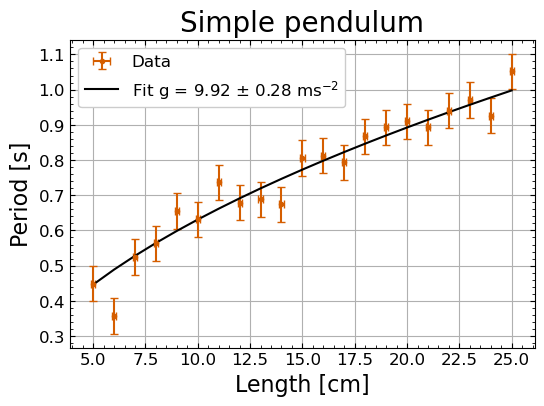

In [3]:
fig = plt.figure(figsize = (6,4)) # set a figure size similar to the default
ax = fig.add_subplot(111)

# If you want a grid, make sure you add this first.
ax.grid() # Make sure we add the grid before our other plots, otherwise it will be displayed on top of other elements

ax.errorbar(X, y, xerr = xerr, yerr = yerr, fmt = '.',label='Data',color='#D55E00',capsize = 3)
ax.set_xlabel('Length [cm]',fontsize = 16)
ax.set_ylabel('Period [s]',fontsize= 16)
ax.set_title('Simple pendulum',fontsize= 20)
ax.plot(X, 2*np.pi*np.sqrt(X/100/g),label = 'Fit g = {:.2f} $\pm$ {:.2f} ms$^{{-2}}$'.format(g, sig_g),color='black')

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1],labels[::-1],loc='upper left',fontsize = 12, framealpha = 1) # Framealpha prevents grid lines from showing through legend

ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')

# These next three lines make more sophisticated ticks on the axes
# I would normally put imports at the start but I place this import just before I use the imported methods.
from matplotlib.ticker import MultipleLocator # makes placing ticks easier; can put major/minor ticks at fixed multiples

ax.xaxis.set_minor_locator(MultipleLocator(0.5)) # tells it to place the small ticks every 0.5 on the horizontal axis
ax.yaxis.set_minor_locator(MultipleLocator(0.02)) # tells it to place the small ticks every 0.02 on the vertical axis


# Section 2: Monte-Carlo

### Monte-Carlo Algorithm 

1. Calculate the cumulative distribution $F(X) = \int_{-\infty}^X f(X') \, dX'$.
1. For properly normalised PDF (and CDF), generate a random number $u$ drawn from the uniform distribution $U(0,1)$ i.e. between $0$ and $1$.
1. Find $X$ such that $F(X) = u$ so that $X=F^{-1}(u)$. (Note that this is effectively a definition of the the "inverse function" $F^{-1}$ which we look at below.)

It is straightforward to repeat this as many times as you need to get a simulated data set drawn from the specified distribution. 

In [ ]:
# Define a standard normal distribution and calculate some numerical data

def standard_normal(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

# Values of X to use here when plotting
Xmin=-5.0
Xmax=5.0
Xstep=0.2
number_values= int(0.5+(Xmax-Xmin)/Xstep) + 1 # the +1 need for even steps from first to last inclusive
X = np.linspace(Xmin, Xmax, number_values) 
y = standard_normal(X)

In [ ]:
# Calculate cumulative distribution from y data; remember to normalise

ycdf = y.cumsum()    # This is not yet normalised but last value is the total
ycdf = ycdf/ycdf[-1] # Use the last value to normalise values 


In [ ]:
# Interpolate to find the inverse function; remember first argument should be cumulative distribution, then X

"""
Note the ordering of arguments in th next line of code.
A smoothed version of the normalised would be ordered CubicSpline(X, ycdf).
To get the smoothed inverse function that we want we switch the order of the arguments CubicSpline(ycdf, X).
"""
inv = CubicSpline(ycdf, X) 

# Check the quality of the spline

fig = plt.figure(figsize = (6,4)) 
ax = fig.add_subplot(111)

ax.plot(ycdf,X,'x', label='Original data',color='black')
ax.plot(ycdf,inv(ycdf),label='Interpolated data',ls='--',color='#D55E00')
ax.legend(loc='lower right')
ax.set_xlabel('$u$',fontsize = 16)
ax.set_ylabel('$F^{-1}(u)$',fontsize =16)
#ax.set_yscale('log') No log scale needed here
ax.set_title('Inverse cumulative distribution',fontsize = 20)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(LogLocator(base = 10.0,numticks =14, subs = [0.2,0.4,0.6,0.8]))


In [ ]:
# Generate three samples from uniform distribution in range [0,1]

# For reproducibility, I like to fix the seed for the random number generator, any number is as good as any other
rng = np.random.default_rng(0) 

u2 = rng.uniform(0,1,size = 100)
u3 = rng.uniform(0,1,size = 1000)
u4 = rng.uniform(0,1,size = 10000)
#u5 = rng.uniform(0,1,size = 100000)


In [ ]:
# Apply inverse function to samples and plot histogram

fig = plt.figure(figsize = (12,4)) 
fig.suptitle('Generated distribution',fontsize = 20)

plot_number=0
for u in [u2,u3,u4]:

    samples = inv(u)
    plot_number+=1 # index of the next plot
    ax = fig.add_subplot(1,3,plot_number)
    ax.set_title('Size= {:d}'.format(len(u)),fontsize = 16)
    
    # Could use other things for the bins but this seems useful
    #ax.plot(X,y*len(u),"-",color="k")
    ax.hist(samples, bins = X,color='#D55E00', label='Artificial data')
    
    
    ax.set_xlabel('X',fontsize = 16)
    ax.set_ylabel('y',fontsize = 16)
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(X[1]-X[0])) # set minor tick interval to bin width
    ax.yaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()


### The Accept-Reject Method [^](#index) <a id='accept-reject'></a>

If the PDF $f(x)$ is too complicated even to invert numerically, then we can always use the accept/reject method. This is particularly useful for functions with discontinuities.  This Accept-Reject method is performed by according to the following steps:

1. Generate a random number $X$ from a uniform distribution over the range of the desired PDF
1. Generate a second random number $y$ from the uniform distribution $h(y)$ = $U(0,a)$ where $a$ is the maximum value of the function $f(X)$ within the range of $X$ values required.  
1. If $y \leq f(X)$, then accept this point; otherwise it is rejected
1. Repeat from (1) until you have the number of points you want.
1. The set of kept values are a set random values $\{X\}$ drawn from a probability distribution with pdf f(X) 

This method only accepts points that lie beneath the desired PDF; because regions of the PDF with higher probability have more "vertical" space available, the density of points accepted in these regions is increased compared to regions of low probability. 

For example, consider a density function defined as $f(X) = -X^2 + 4$ for the range $-2 \leq X \leq 2$. The code cell below shows how we can use the accept-reject method on this function.

In [ ]:
# Define the function. Note this is NOT normalised.
# Note for a more complicated function with discontinuities we just need more code with "if" statements
def f(x):
    return -x**2 + 4

# We want to generate values within the range X=-2..2. 
# We need $a$ the maximum value of $f(X)$ in that range which we set by hand
a_value = f(0.0)

# For reproducibility, I like to fix the seed for the random number generator, any number is as good as any other
rng = np.random.default_rng(0) 

# Generate uniform X samples in the region of interest
x_samples = rng.uniform(-2,2,size = 5000)

# Generate uniform y samples in U(0, max(f(X)) (where the max(f(X) here is at f(0))
y_samples = rng.uniform(0,a_value,size = 5000)

# Find which samples fulfill the criteria y <= f(X);
# This is an array of True and False values 
accept = (y_samples <= f(x_samples))

# Plot the PDF, envelope function, and some samples
fig, ax = plt.subplots(1,1,figsize = (9,7))
# Next draw box containing all the points which are drawn
ax.plot([-2,-2,2,2],[0,a_value,a_value,0],ls='--',color='grey',label='Envelope function $h(y)$')
# Next draw function
ax.plot(np.linspace(-2,2,100),f(np.linspace(-2,2,100)),label='$f(X)$',color='black')
ax.set_xlim(-2.2,2.2)
ax.set_ylim(0,1.35*a_value) # leave a little space at the top for the legend
ax.set_xlabel('$X$',fontsize = 18)
ax.set_ylabel('$y$',fontsize = 18)
ax.tick_params(labelsize = 14,which='both')
# Next plot ALL the points tried as failed points 
ax.scatter(x_samples, y_samples, s = 1, label='Rejected samples', color='#56B4E9')
# but then for the points we accept we plot another point to indicate accepted points as this will be on top and seen by us
ax.scatter(x_samples[accept],y_samples[accept],s = 1,c='#D55E00',label = 'Accepted samples')
ax.legend(loc='upper center',fontsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

# Section 3: Stats

### K-S Tests

Named after Andrey Kolmogorov and Nikolai Smirnov, the Kolmogorov-Smirnov test, often just the K-S test or the KS test, is one of the most common goodness of fit tests. It is used in two ways.

The **one-sample** KS test compares a data sample with a reference probablity distribution. The question this test asks is
* how likely is it that we would see these data samples if the data is drawn from that probability distribution?

The **two-sample** KS test compares two different data samples. This test asks
* how likely is it that we would see these two sets of data samples if they are drawn from the same (but unknown) probability distribution?

The KS test is based around the CDF (cumulative probability distribution) not the PDF (probability density function). So to test empirical data, we first need to define the the **empirical cumulative distribution** of the data $F_{\text{data}}(X)$. This is defined as follows:

\begin{equation*}
F_{\text{data}}(X) = \frac{\text{number of data values} < X}{n},
\end{equation*}
where $n$ is the number of measurements in the dataset. 

# Section 4: Fitting

Refer back to worksheet

# Section 5: kNN

## Supervised, Unsupervised, Semisupervised, and Reinforcement Learning

**Supervised learning** builds a model using existing data with a **known desired output** (called labels) where we want to predict the outcome for new observations of the input. We say that this training data is **labelled**. Most of the machine learning that we carry out in the physical sciences (and the world at large) is supervised. The existing data is called **training data** and is used to train the model. Some examples of supervised learning include:
* **Regression**: predicting a continuous output value. 
    * Example: predicting the price of a car based on characteristics of the car
<br>
<br/>


* **Binary classification**: classifying data into one of two classes. 
    * Example: classifying emails as spam or not
<br>
<br/>

* **Multiclass classification**: classifying data into one of multiple classes. 
    * Example: facial recognition against a database of faces
    
We will talk more about classification and regression later in this notebook.


**Unsupervised learning** is where you don't have a known desired output, aka where the training data is **unlabelled**, so you are trying to build a model based on other properties. We find patterns based on similarities or differences of data points. Common examples include:
* **Clustering**: grouping data into categories without any prior information 
    * Example: social network friend suggestions


In [ ]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score




# Note: it is convention to label X as capital and y as lowercase
X, y = make_blobs(300,2, center_box=(-5,5), centers = 2, random_state = 2) 

df_toy = pd.DataFrame(X,columns=['Feature 1','Feature 2'])
pd.plotting.scatter_matrix(df_toy, figsize = (6,6), c = y, hist_kwds={'edgecolor':'black','alpha':0.5}, cmap = cm.cividis)


# Take 20% of the data out for testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 3) 

In [ ]:
# hyperparameter loop
df = pd.DataFrame(columns=['n_neighbors','weights','test_accuracy'])

list_of_weights = ['uniform','distance']
list_of_neighbors = [3, 8, 15, 25, 40]

# Use a list comprehension to make a list with each possible combination of these values
for weights, neighbors in [(w, n) for w in list_of_weights for n in list_of_neighbors]:
    model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    df = pd.concat([df, pd.DataFrame([{'n_neighbors':neighbors,'weights':weights,'test_accuracy':acc}])])

# Section 6: Support Vector

## An aside on preprocessing

In the case of applying a linear kernel to non-linear data, we have discussed adding new features to our data to try to simplify the problem or make it easier for our algorithm to solve the problem. However, this is not the only type of **preprocessing** we can do to help in ML; some examples include:

* Rescaling: transforming your data into a specific range, e.g. such that all of your input features are between 0 and 1 or between -1 and 1. If the scale between different features is significantly different then one feature can influence the training more than others.
<br>

* Encoding categorical features: some datasets will have non-numeric data, e.g. whether a house has a garden or not, which must be transformed into numerical data for the purposes of training a machine learning algorithm. 
<br>

* Discretization: turning a continuous variable into a series of categories, e.g. applying binning to data. 

In scikit-learn, `sklearn.preprocessing` contains many useful tools for preprocessing data, such as `StandardScaler`, which scales data to a standard normal distribution i.e. a Gaussian with $\mu = 0$ and $\sigma = 1$.

You can also arrange preprocessing operations into a so-called **pipeline** with machine learning models, using the function `make_pipeline` from `sklearn.pipeline`. An example of composing a pipeline can be seen in the code cell below.

# Section 7: Performance Metrics

We can define derived quantities from these that express different things about the model:

* **Accuracy**: as we have seen already, this is the proportion of samples that are classified correctly
<br>

\begin{equation*}
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation*}
<br>

* **Fall-out or False Positive Rate**: the proportion of points with $y$ = -1 that are incorrectly predicted as $\hat{y}$ = +1
<br>

\begin{equation*}
\text{Fall-out} = \frac{\text{+1 predictions with true class -1}}{\text{Points with true class -1}} = \frac{FP}{FP + TN}
\end{equation*}
<br>

* **Precision**: the proportion of points with predicted to have class +1 that have true class +1 i.e. fraction of predictions of class +1 that are correct
<br>

\begin{equation*}
\text{Precision} = \frac{\text{+1 class predictions with true class +1}}{\text{Predictions of class +1}} = \frac{TP}{TP + FP}
\end{equation*}
<br>

* **Recall or True Positive Rate**: fraction of points with true class +1 that are correctly identified as class +1
<br>

\begin{equation*}
\text{Recall} = \frac{\text{+1 class predictions with true class +1}}{\text{Points with true class +1}} = \frac{TP}{TP + FN}
\end{equation*}

In [2]:
waveforms_data = np.load('week07/nf_waveforms_dset.npy', allow_pickle = True).item()
from sklearn.model_selection import train_test_split

X = waveforms_data['data']
y = waveforms_data['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

from sklearn.svm import SVC

svc1 = SVC(C = 1, kernel = 'rbf')
svc2 = SVC(C = 1, kernel = 'sigmoid')

svc1.fit(X_train, y_train)
svc2.fit(X_train, y_train)

SVC(C=1, kernel='sigmoid')

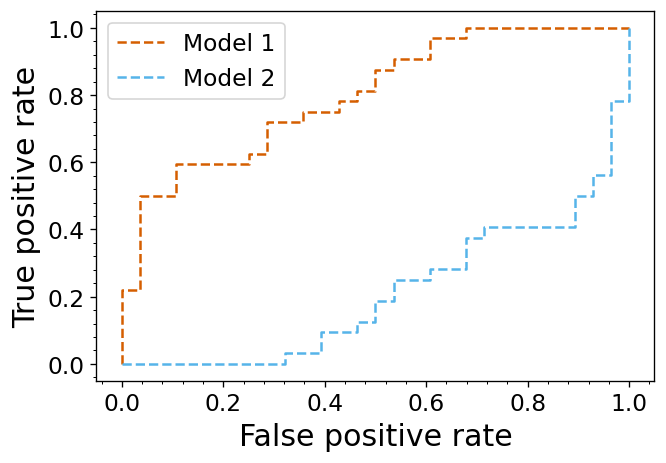

In [3]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

y_score1 = svc1.decision_function(X_test) # Calculate scores for test points
y_score2 = svc2.decision_function(X_test) # Calculate scores for test points

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1) # Find ROC curve values
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_score2)

fig, ax = plt.subplots(1,1,figsize = (6,4), dpi = 120)

ax.plot(fpr1, tpr1,color='#D55E00', label='Model 1',ls='--') # Plot the ROC curve
ax.plot(fpr2, tpr2, color='#56B4E9', label = 'Model 2', ls = '--')
ax.set_xlabel('False positive rate',fontsize = 18)
ax.set_ylabel('True positive rate', fontsize = 18)
ax.tick_params(which='both',labelsize = 14)
ax.legend(loc='upper left',fontsize = 14)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))

In [4]:
from sklearn.metrics import roc_auc_score

print('Model 1 ROC-AUC: {:.3f}'.format(roc_auc_score(y_test, y_score1)))
print('Model 2 ROC-AUC: {:.3f}'.format(roc_auc_score(y_test, y_score2)))

Model 1 ROC-AUC: 0.799
Model 2 ROC-AUC: 0.210


In [6]:
from scipy.stats import kstest
import pandas as pd

poly_df = pd.read_hdf('week07/poly_data.h5')

X, y = poly_df['input'].values, poly_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, train_size = 0.8, test_size = 0.2, random_state = 1)

In [7]:
from sklearn.svm import SVR

poly_model = SVR(kernel='poly',degree=4,epsilon=10,coef0=2,C=1)
rbf_model = SVR(kernel='rbf',gamma = 20, coef0=2, epsilon = 10, C = 100)

poly_model.fit(X_train, y_train)
rbf_model.fit(X_train, y_train)

SVR(C=100, coef0=2, epsilon=10, gamma=20)

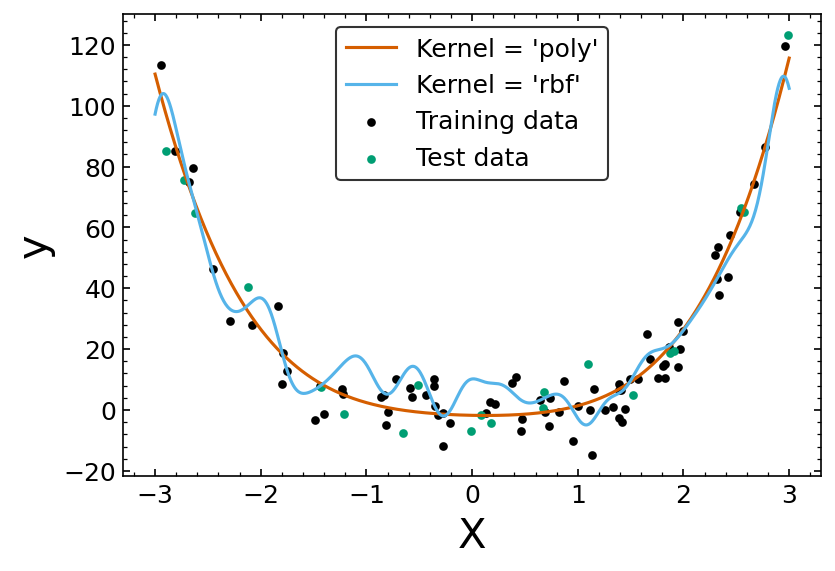

In [8]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)

X_plot = np.linspace(-3,3,1000).reshape(-1,1)

ax.plot(X_plot,poly_model.predict(X_plot), color='#D55E00', label = "Kernel = 'poly'")
ax.plot(X_plot, rbf_model.predict(X_plot), color='#56B4E9',label = "Kernel = 'rbf'")
ax.scatter(X_train, y_train, color='black',label='Training data', s = 10)
ax.scatter(X_test, y_test, color='#009E73',label='Test data', s = 10 )
ax.set_xlabel('X',fontsize = 20)
ax.set_ylabel('y',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(which='both',labelsize = 12,direction='in',top=True,right=True)
ax.legend(loc='upper center',fontsize = 12, edgecolor='black')

In [9]:
print('poly kernel model:')
print(kstest(poly_model.predict(X_test), y_test))
print('')

print('rbf kernel model')
print(kstest(rbf_model.predict(X_test), y_test))

poly kernel model:
KstestResult(statistic=0.15, pvalue=0.9831368772656193)

rbf kernel model
KstestResult(statistic=0.35, pvalue=0.17453300569806826)


In [12]:
# more hyperparam iterating 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
results_df = pd.DataFrame(columns=['kernel','C','epsilon','degree','gamma','coef0','MAE','MSE','RMSE','R2','KS-statistic','KS-p-value'])

# Doing it as a list of hyperparameter tuples to more effectively iterate over kernels etc
# In order: (kernel, C, epsilon, degree, gamma, coef0)

list_of_hyparams = [('poly', 1, 10, 4, 'scale', 2),
                    ('poly', 100, 10, 4, 'scale', 2),
                    ('rbf', 1, 10, 3, 'scale', 2),
                    ('rbf', 100, 10, 3, 'scale', 2),
                    ('linear', 1, 10, 3, 'scale', 2),
                    ('linear', 100, 10, 3, 'scale', 2),
                    ('sigmoid', 1, 10, 3, 'scale', 2),
                    ('sigmoid', 100, 10, 3, 'scale', 2)]

best_rmse = 100000

for kernel, C, epsilon, degree, gamma, coef0 in list_of_hyparams:
    svr = SVR(kernel = kernel, C = C, epsilon = epsilon, degree = degree, gamma = gamma, coef0 = coef0)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)
    ks_result = kstest(y_test, y_pred)
    model_df = pd.DataFrame(np.array([[kernel, svr.C, svr.epsilon, svr.degree,svr.gamma,svr.coef0,mae, mse, rmse, r2, ks_result.statistic, ks_result.pvalue]]),
                          columns=['kernel','C','epsilon','degree','gamma','coef0','MAE','MSE','RMSE','R2','KS-statistic','KS-p-value'])
    results_df = pd.concat([results_df, model_df])
    

# Section 8: Decision Trees

[Text(0.4, 0.8333333333333334, 'x[3] <= 0.8\ngini = 0.666\nsamples = 120\nvalue = [42, 39, 39]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 42\nvalue = [42, 0, 0]'),
 Text(0.6, 0.5, 'x[3] <= 1.65\ngini = 0.5\nsamples = 78\nvalue = [0, 39, 39]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.095\nsamples = 40\nvalue = [0, 2, 38]')]

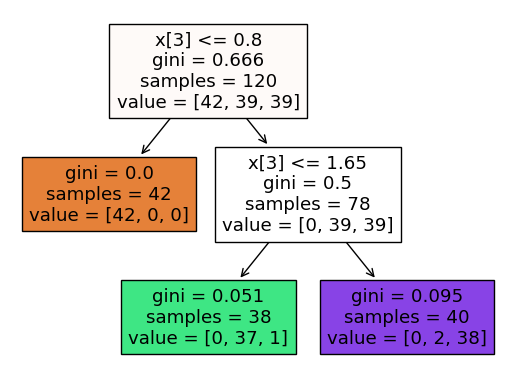

In [14]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
# Keep same random state for consistency
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size = 0.2, random_state = 20) 

clf = tree.DecisionTreeClassifier(max_depth = 2, random_state = 1)

clf.fit(X_train, y_train)

tree.plot_tree(clf, filled = True)

We can talk about three different kinds of node:

* The **root node** is the first node of the decision tree
<br>

* **Internal nodes** (or sometimes just nodes) are nodes with branches to and away from them
<br>

* A **leaf** is a node at the end of a branch, with no further branches. This is where we make a prediction.

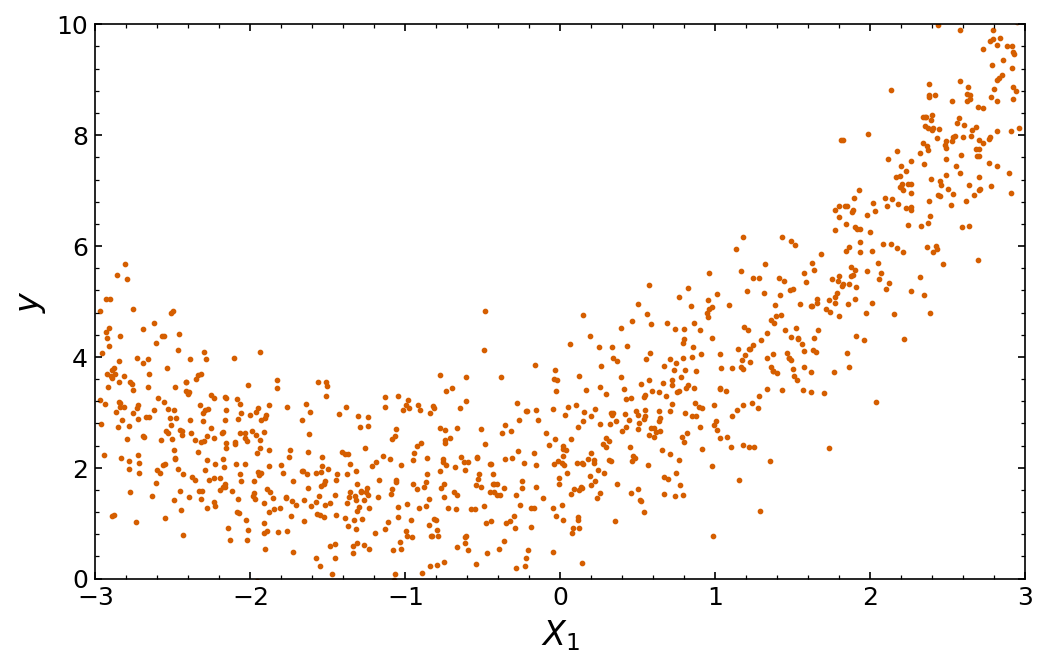

In [15]:
from matplotlib.ticker import MultipleLocator

np.random.seed(42) # Set the seed for consistency

# Generate training data
X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')

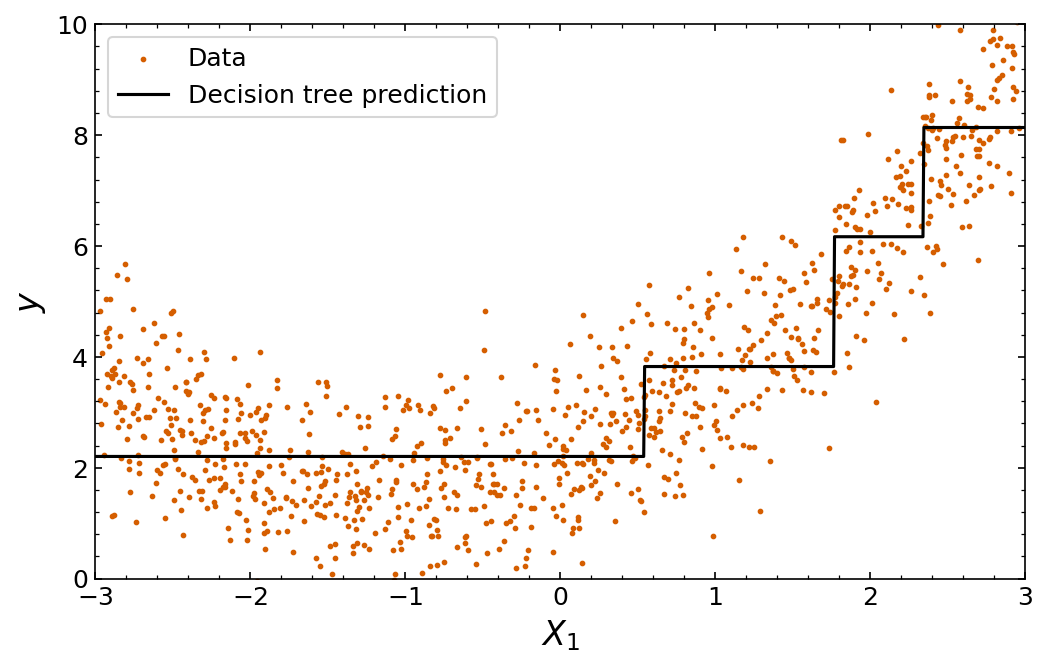

In [16]:
# Define and fit the decision tree
reg = tree.DecisionTreeRegressor(max_depth = 2, random_state = 1)
reg.fit(X,y)

# Plot the results
xs = np.linspace(-3,3,1000)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3, label = 'Data')

ys = reg.predict(xs.reshape(-1,1))
ax.plot(xs, ys, color='black',label='Decision tree prediction')

ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')
ax.legend(loc='upper left',fontsize = 12)

In [ ]:
import pickle

list_of_depth = [2, 3, 4, 5, 10, 20, 100, None]
list_of_min_split = [2, 3, 4, 5, 10]
list_of_min_samples = [1, 2, 5]

list_of_hparams = [(d, sp, sa) for d in list_of_depth for sp in list_of_min_split for sa in list_of_min_samples]
#from itertools import product
#combinations=product(*hyperparams_list)

results_df = pd.DataFrame(columns=['max_depth','min_samples_split','min_samples_leaf','accuracy'])

best_acc = 0
for max_depth, min_samples_split, min_samples_leaf in list_of_hparams:
    # Note: fix random state as decision trees shuffle data, and the order in which data is shown matters
    clf = tree.DecisionTreeClassifier(max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  random_state = 1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    if acc>best_acc:
        best_acc = acc
        with open('best_iris_dt.pkl','wb') as f:
            pickle.dump(clf, f)
    model_df = pd.DataFrame(np.array([[max_depth, min_samples_split, min_samples_leaf, acc]]),
                            columns = results_df.columns)
    results_df = pd.concat([results_df, model_df])

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons


X, y = make_moons(n_samples = 300, noise = 0.25, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

clf = RandomForestClassifier(n_estimators = 500, 
                             max_samples = 100, 
                             bootstrap = True,
                             n_jobs = 4,
                             oob_score = True,
                             max_leaf_nodes = 20, # Limit individual tree size by requiring no more than 20 leaf nodes
                             random_state = 1) 

clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=20, max_samples=100, n_estimators=500,
                       n_jobs=4, oob_score=True, random_state=1)

OOB score = 0.8916666666666667
Test accuracy = 0.9666666666666667


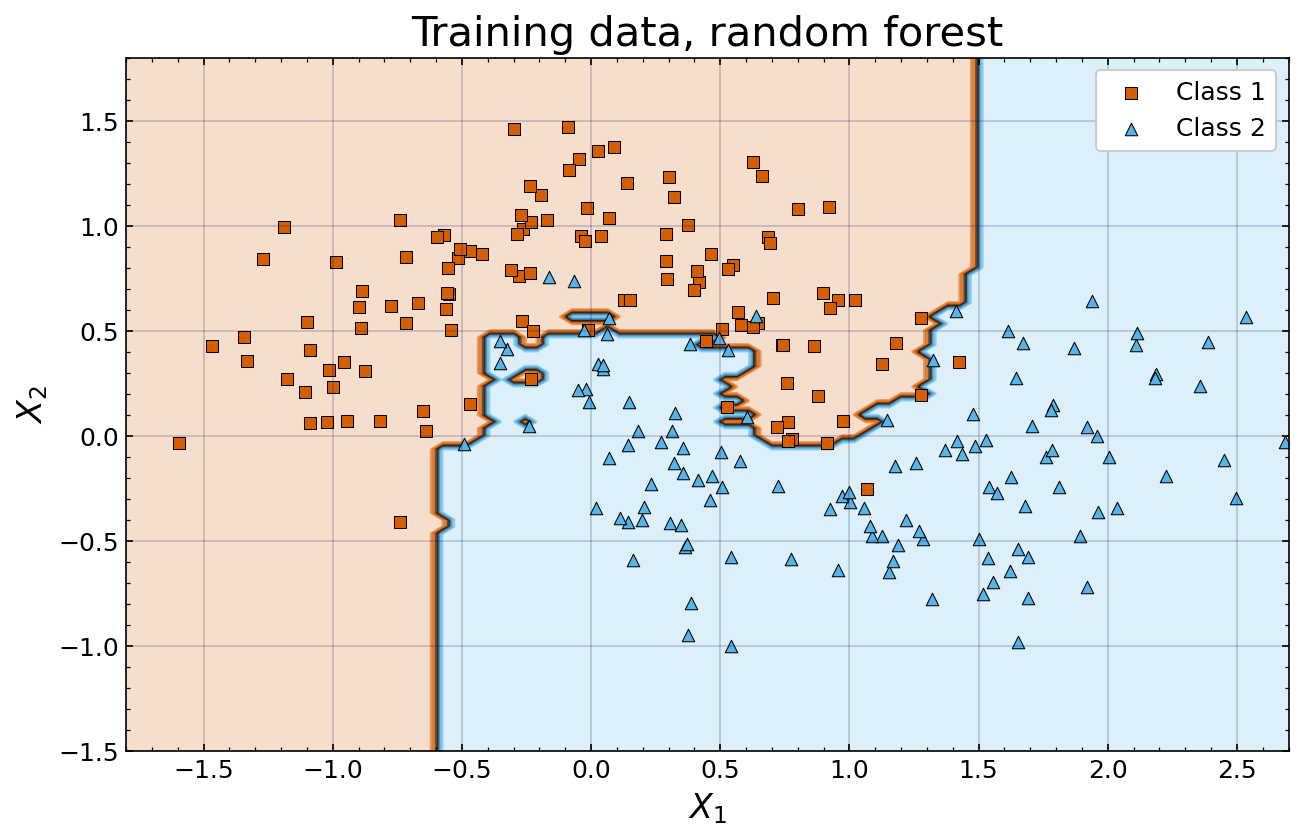

In [21]:
# decision boundary plot
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

x1s, x2s = np.linspace(-1.8,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
# To get matching colours, we need to define our own colourmap
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])

fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Training data, random forest',fontsize = 20)

pred = clf.predict(X_test)
print('OOB score = {}'.format(clf.oob_score_))
print('Test accuracy = {}'.format(accuracy_score(y_test,pred)))

# Section 9: Neural Networks 

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split

X_torch = torch.randn(200, 2)
y_torch = torch.randn(200,1)

dataset = TensorDataset(X_torch, y_torch)
dataset_train, dataset_test = random_split(dataset, lengths = [0.8,0.2]) # Split dataset into separate datasets for training & testing

from torch.utils.data import DataLoader

dloader_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
dloader_test = DataLoader(dataset_test, batch_size = 32, shuffle = True)

In [42]:
from sklearn.datasets import make_classification
import numpy as np

n_samples = 300
np.random.seed(42)

X, y = make_classification(n_features = 2, 
                           n_redundant = 0, 
                           n_samples = n_samples, 
                           n_informative = 2, 
                           random_state = 6, 
                           class_sep = 1, 
                           n_clusters_per_class=1)

X_torch = torch.tensor(X).float()
y_torch = torch.tensor(y).float()

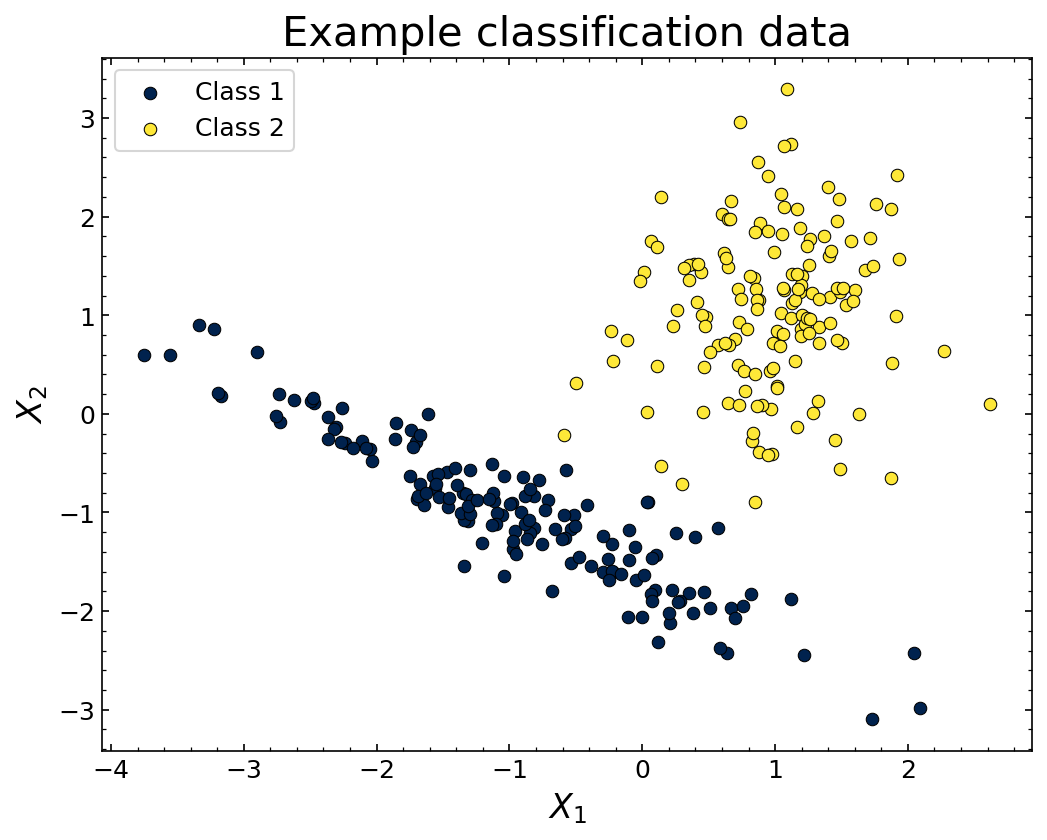

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
ax.scatter(X[:,0][y==0],X[:,1][y==0], color = '#00224E', label='Class 1', edgecolor='black', lw = 0.5)
ax.scatter(X[:,0][y==1],X[:,1][y==1], color = '#FEE838', label='Class 2', edgecolor='black', lw = 0.5)
# ax.scatter(X[:,0], X[:,1], c = y, cmap = cm.cividis)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',top=True,right=True,direction='in',labelsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_title('Example classification data',fontsize = 20)
ax.legend(loc='upper left',fontsize = 12)


In [44]:
torch.manual_seed(5)

model = nn.Sequential(nn.Linear(2,10),
                      nn.ReLU(),
                      nn.Linear(10,1),
                      nn.Sigmoid())

In [49]:
dataset = TensorDataset(X_torch, y_torch)
dataset_train, dataset_validate, dataset_test = random_split(dataset, lengths = [0.6,0.2,0.2], generator = torch.Generator().manual_seed(2)) # Split dataset into separate datasets for training & testing

dloader_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
dloader_validate = DataLoader(dataset_validate, batch_size = 32, shuffle = True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_fcn = nn.BCELoss()

In [50]:
def train_epoch():
    tot_loss = 0
    valid_loss = 0
    for X_train, y_train in dloader_train:
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train.reshape(-1,1))
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
    
    for X_valid, y_valid in dloader_validate:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid.reshape(-1,1))
        valid_loss += vloss.detach()
    
    return tot_loss/len(dataset_train), valid_loss/len(dataset_validate)

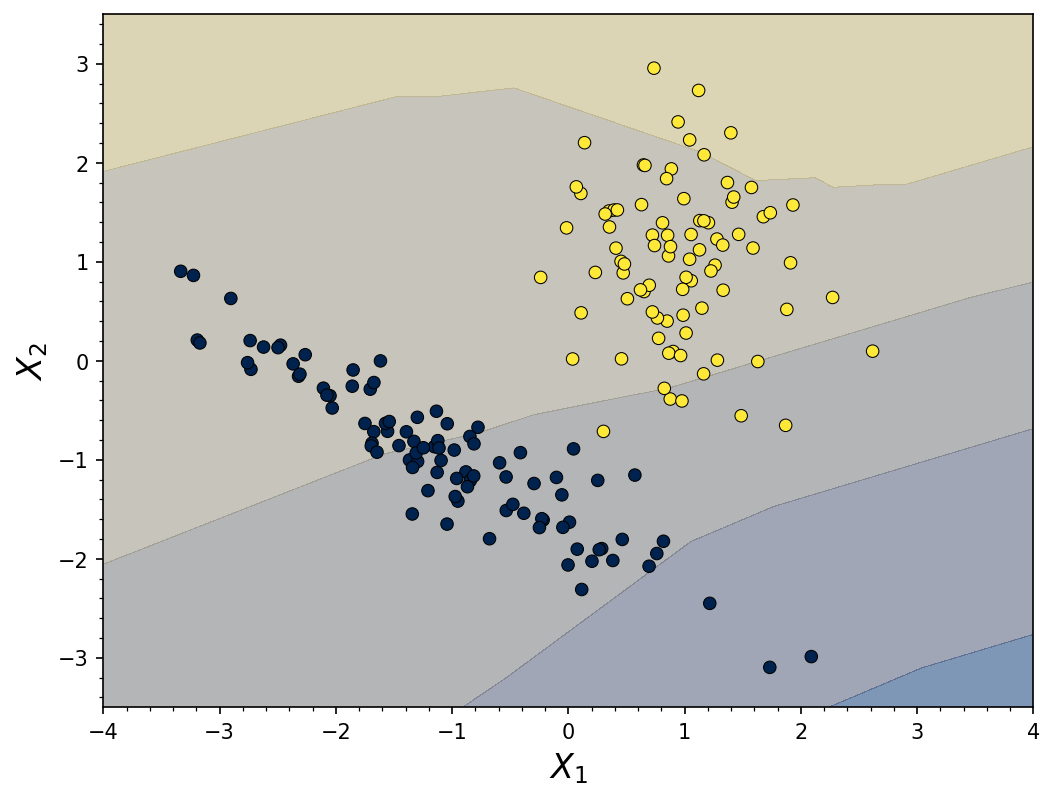

In [51]:
X_train = torch.vstack([dataset_train[i][0] for i in range(len(dataset_train))])
y_train = torch.vstack([dataset_train[i][1] for i in range(len(dataset_train))])
X_valid = torch.vstack([dataset_validate[i][0] for i in range(len(dataset_validate))])
y_valid = torch.vstack([dataset_validate[i][1] for i in range(len(dataset_validate))])#
X_test = torch.vstack([dataset_test[i][0] for i in range(len(dataset_test))])
y_test = torch.vstack([dataset_test[i][1] for i in range(len(dataset_test))])


def plot_decision_boundary(ax, scatter_x, scatter_y):
    N = 1000
    X_grid = np.meshgrid(np.linspace(-7,7,N),np.linspace(-7,7,N))
    X_grid2 = np.array([X_grid[0].flatten(),X_grid[1].flatten()])
    preds = model(torch.tensor(X_grid2.transpose()).float()).reshape((N, N)).detach()
    ax.contourf(X_grid[0],X_grid[1], preds, cmap = plt.cm.cividis, alpha = 0.5)
    ax.scatter(scatter_x[:,0],scatter_x[:,1],c = scatter_y, cmap = plt.cm.cividis, edgecolor='black',lw = 0.5)
    ax.set_xlabel('$X_1$',fontsize = 16)
    ax.set_ylabel('$X_2$',fontsize = 16)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3.5,3.5)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))

fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
plot_decision_boundary(ax, X_train, y_train)


tensor(0.0198)
tensor(0.0186)
tensor(0.0172)
tensor(0.0160)
tensor(0.0147)
tensor(0.0134)
tensor(0.0122)
tensor(0.0110)
tensor(0.0101)
tensor(0.0090)
tensor(0.0082)
tensor(0.0075)
tensor(0.0070)
tensor(0.0062)
tensor(0.0057)
tensor(0.0054)
tensor(0.0049)
tensor(0.0046)
tensor(0.0044)
tensor(0.0039)
tensor(0.0037)
tensor(0.0035)
tensor(0.0033)
tensor(0.0031)
tensor(0.0030)


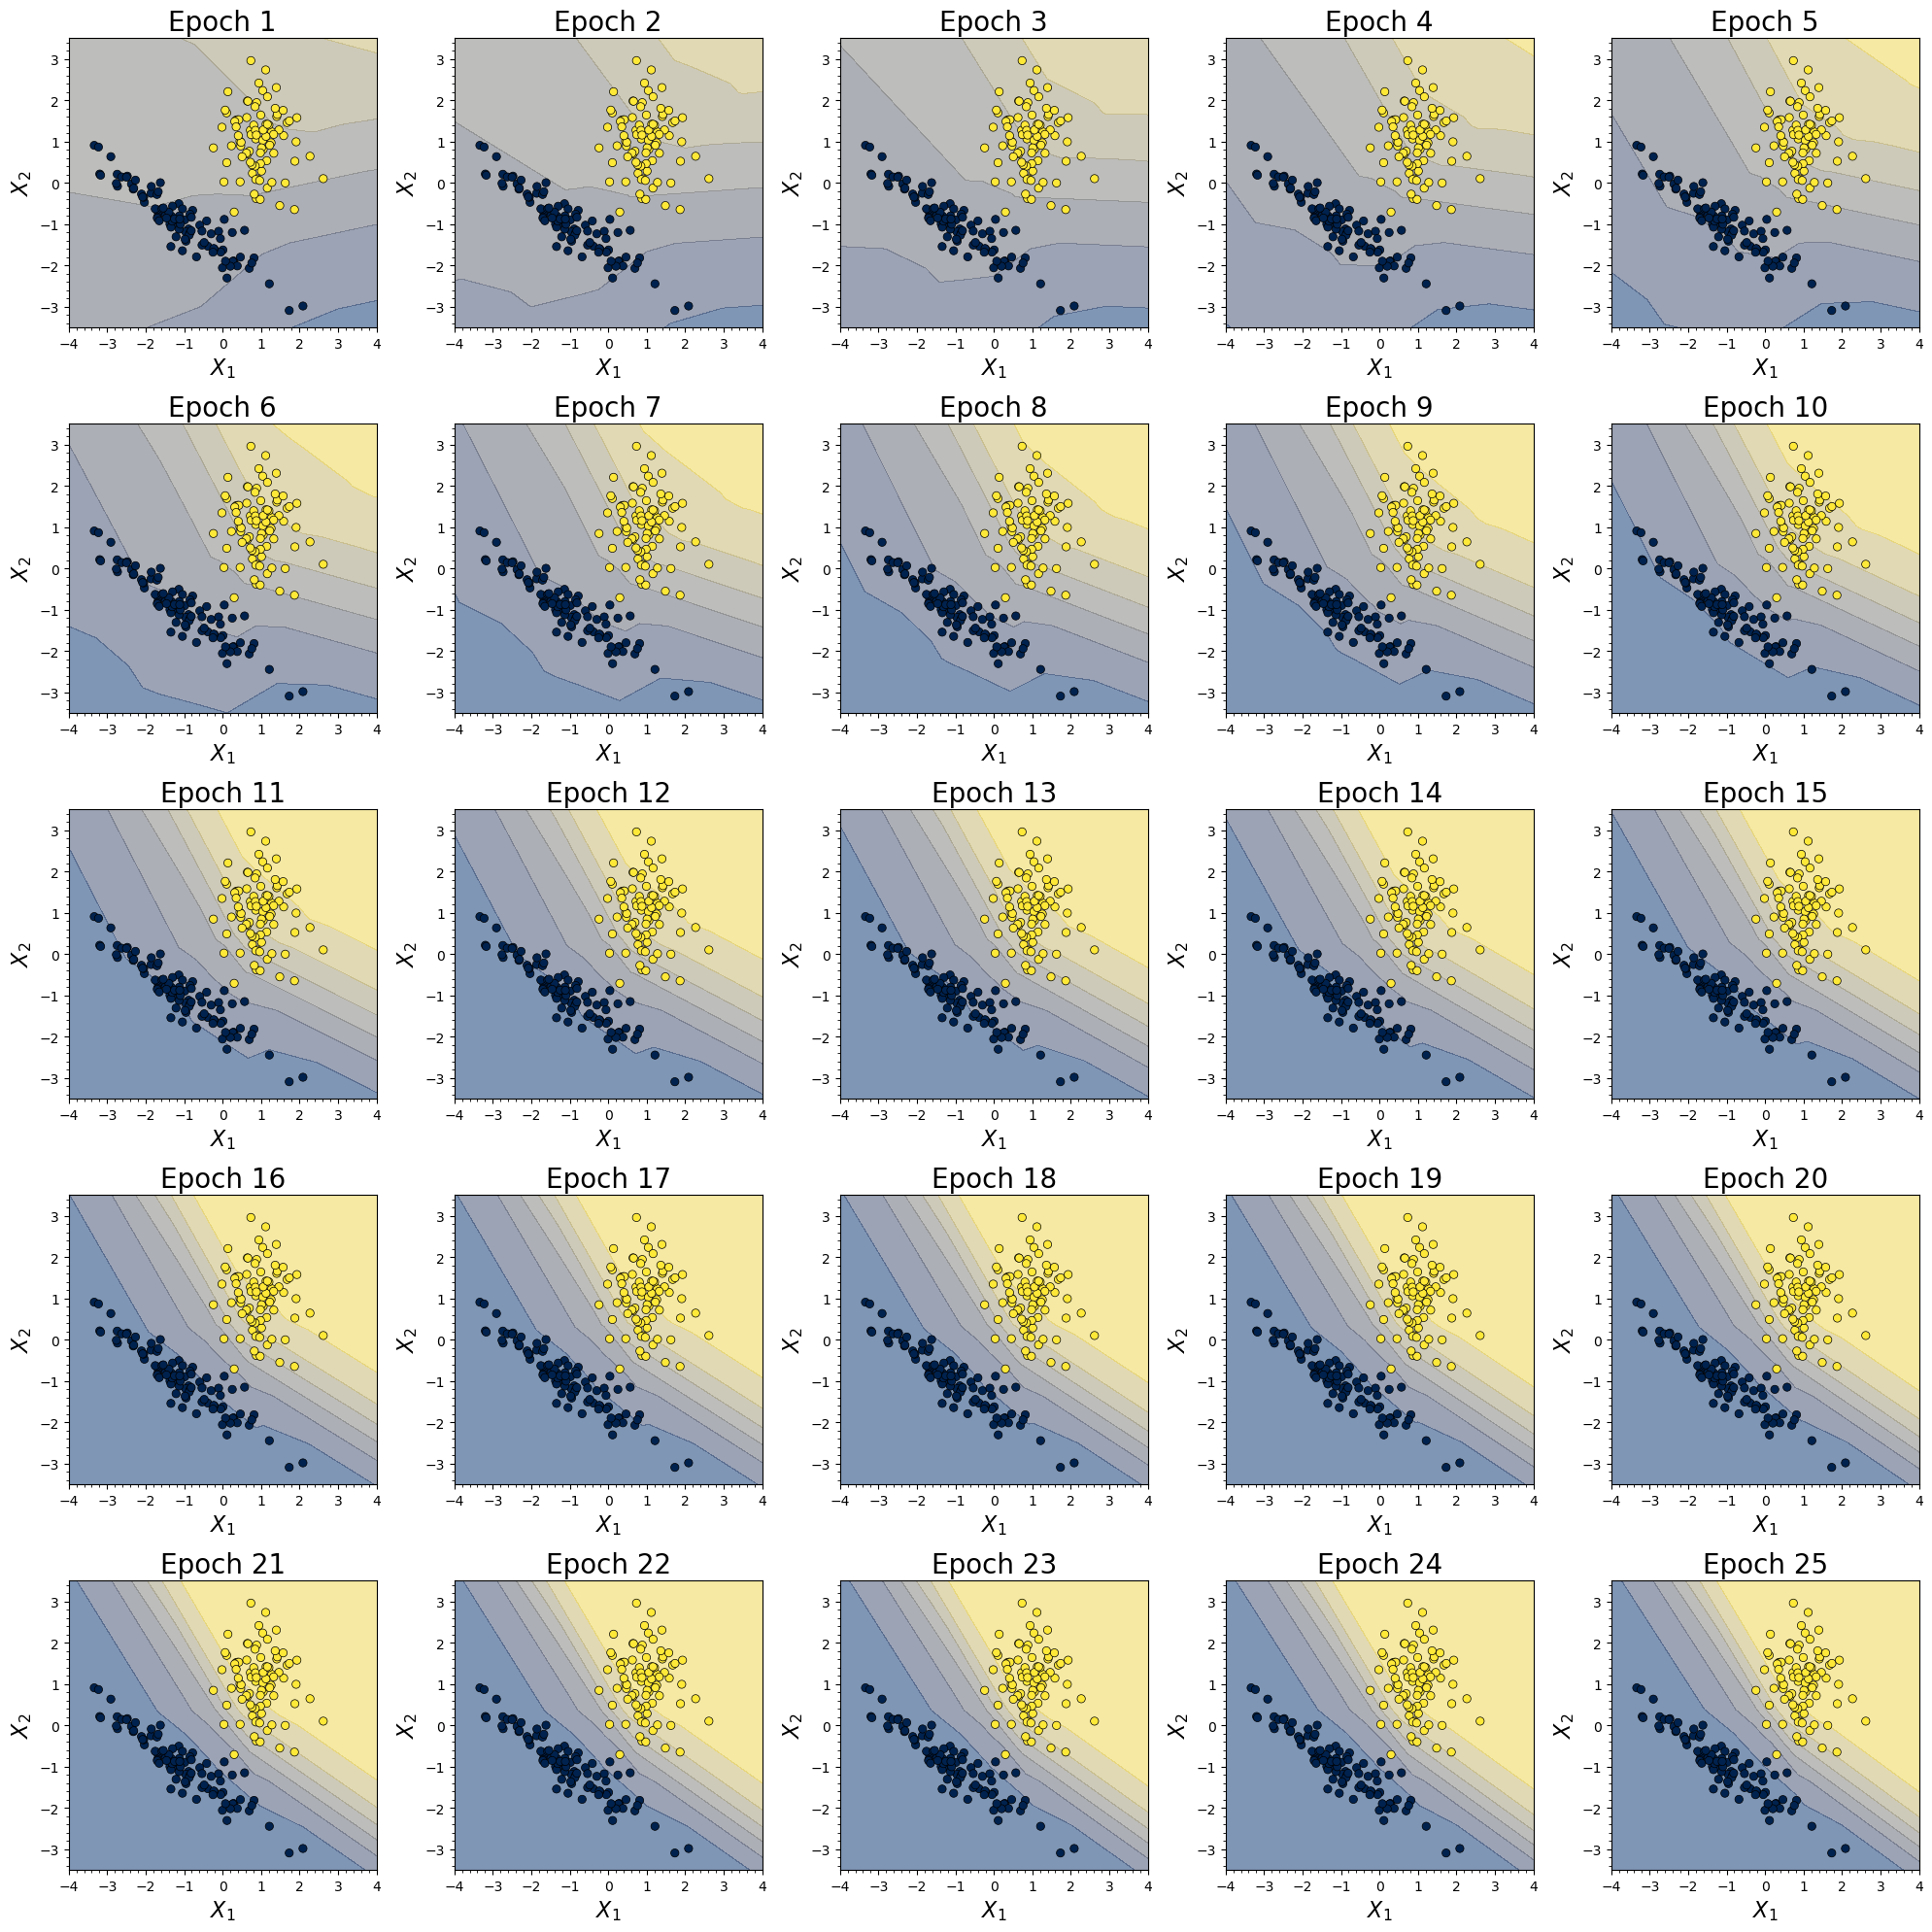

In [52]:
fig, ax = plt.subplots(5,5,figsize = (20,20))

t_loss, v_loss = [],[]
for i in range(25):
    train_loss,valid_loss = train_epoch()
    t_loss.append(train_loss)
    v_loss.append(valid_loss)
    plot_decision_boundary(ax[int(i/5), i%5], X_train, y_train)
    ax[int(i/5),i%5].set_title('Epoch {}'.format(i+1),fontsize = 20)
    print(train_loss)

fig.tight_layout()

Text(0.5, 1.0, 'Validation data')

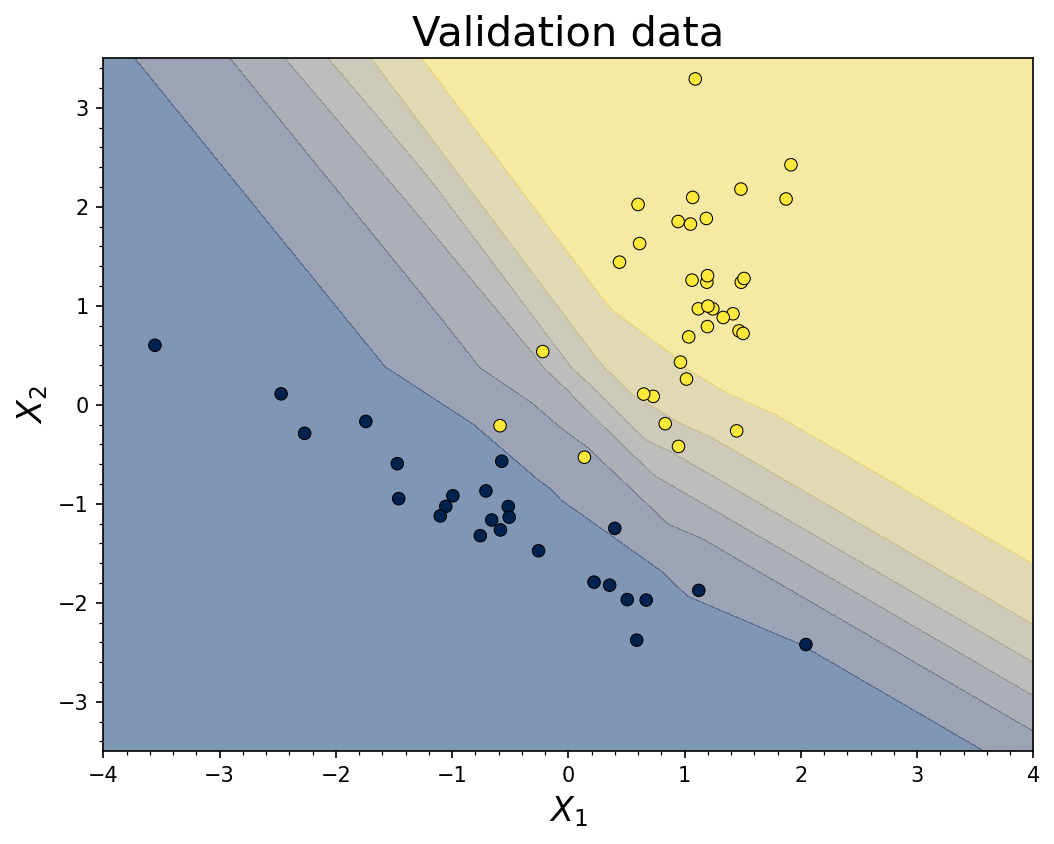

In [53]:
fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
plot_decision_boundary(ax, X_valid, y_valid)
ax.set_title('Validation data',fontsize = 20)

In [54]:

train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
train_accuracy = accuracy_score(y_train, train_pred)

valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)
valid_accuracy = accuracy_score(y_valid, valid_pred)

print('Training accuracy = {:.1f}%'.format(train_accuracy*100))
print('Validation accuracy = {:.1f}%'.format(valid_accuracy*100))

Training accuracy = 98.9%
Validation accuracy = 96.7%


In [55]:
import pandas as pd

hidden_neurons = [20, 50, 100]
activ_functions = {'sigmoid':nn.Sigmoid(), 'ReLU':nn.ReLU(), 'Swish':nn.SiLU()}
learning_rates = [0.01, 0.005, 0.001]

loss_fcn = nn.BCELoss(reduction='sum')
best_val_acc = 0
best_roc = 0

results_df = pd.DataFrame(columns=['hidden_neurons','activ_functions','learning_rate','train_accuracy','validation_accuracy','validation_roc_score'])

for n in hidden_neurons:
    for key in activ_functions.keys():
        for lr in learning_rates:
            torch.manual_seed(1)
            model = nn.Sequential(nn.Linear(2, n),
                                            activ_functions[key],
                                            nn.Linear(n, 1),
                                            nn.Sigmoid())
            optimizer = torch.optim.SGD(model.parameters(), lr = lr)
            tloss, vloss = [], []
            for i in range(25):
                train_loss, valid_loss = train_epoch()
                tloss.append(train_loss)
                vloss.append(valid_loss)
            train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
            valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)
            train_acc = accuracy_score(y_train, train_pred)
            valid_acc = accuracy_score(y_valid, valid_pred)
            valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')
            elif valid_acc==best_val_acc and valid_roc > best_roc:
                best_roc = valid_roc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')
                
            model_df = pd.DataFrame(np.array([[n, key, lr, train_acc, valid_acc, valid_roc]]), columns = results_df.columns)
            results_df = pd.concat([results_df, model_df])
            

Train accuracy = 99.4%
Validation accuracy = 96.7%
Training ROC-AUC score = 1.000
Validation ROC-AUC score = 1.000


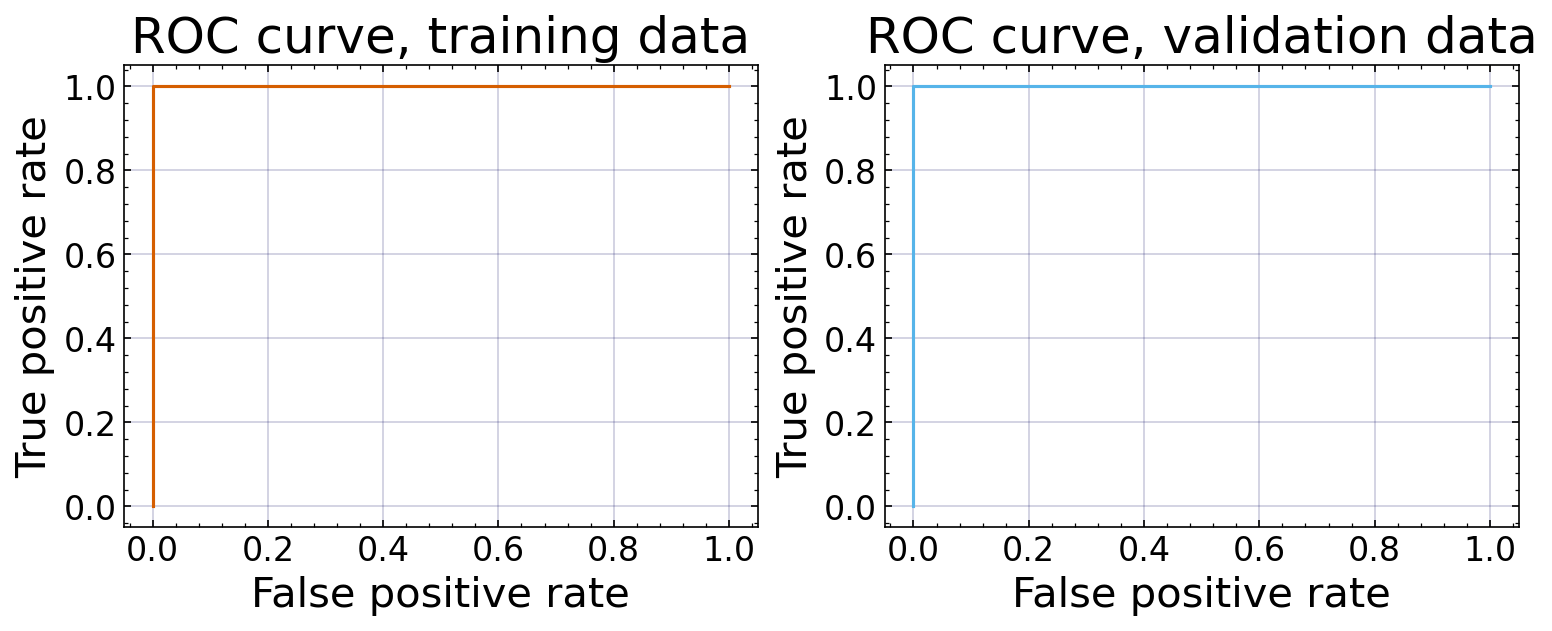

In [56]:
model = torch.load('best_toy_nn_model.pt')
tloss, vloss = np.load('best_toy_nn_losses.npy')

train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)

train_acc = accuracy_score(y_train, train_pred)
valid_acc = accuracy_score(y_valid, valid_pred)

print('Train accuracy = {:.1f}%'.format(train_acc*100))
print('Validation accuracy = {:.1f}%'.format(valid_acc*100))

train_roc = roc_auc_score(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
train_fpr, train_tpr, train_thresholds = roc_curve(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_fpr, valid_tpr, valid_thresholds = roc_curve(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
fig, axs = plt.subplots(1,2,figsize = (12, 4), dpi = 150)
axs[0].plot(train_fpr, train_tpr, color='#D55E00', label = 'Training')
axs[1].plot(valid_fpr, valid_tpr, color='#56B4E9', label = 'Validation')
axs[0].set_title('ROC curve, training data',fontsize = 24)
axs[1].set_title('ROC curve, validation data',fontsize = 24)

for ax in axs:
    ax.set_xlabel('False positive rate',fontsize = 20)
    ax.set_ylabel('True positive rate',fontsize = 20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.04))
    ax.yaxis.set_minor_locator(MultipleLocator(0.04))
    ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
    ax.grid(color='xkcd:dark blue',alpha = 0.2)

print('Training ROC-AUC score = {:.3f}'.format(train_roc))
print('Validation ROC-AUC score = {:.3f}'.format(valid_roc))
                      

Test accuracy = 96.7%


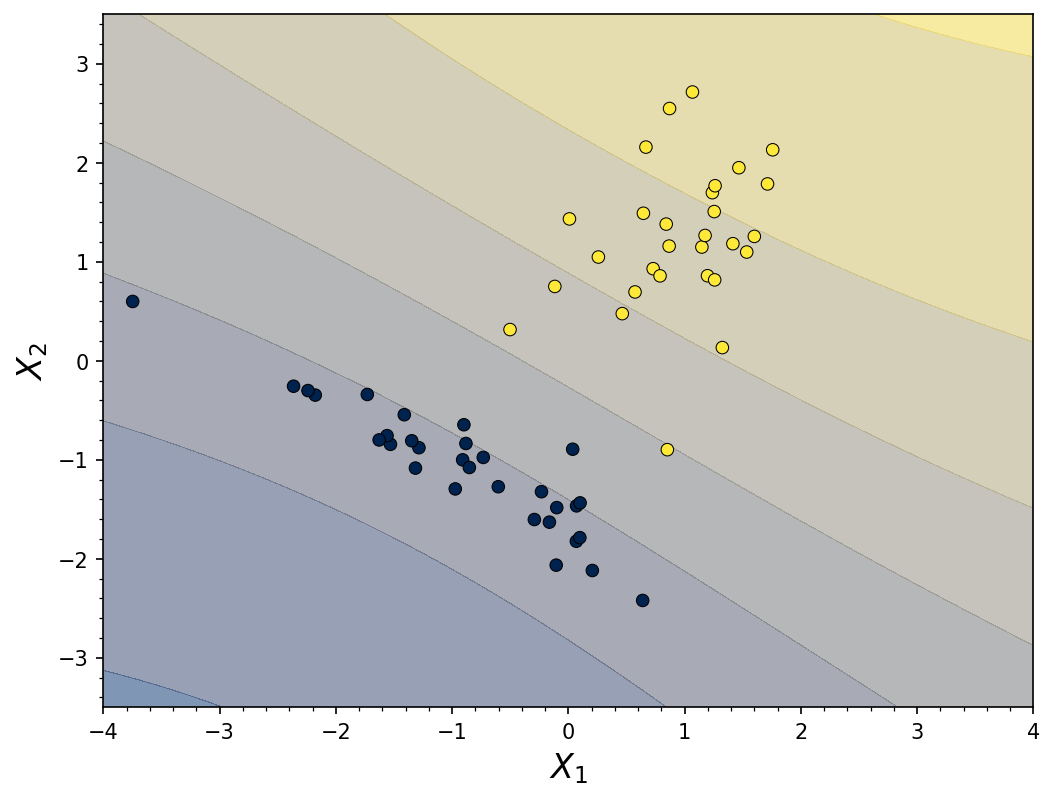

In [57]:
fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
plot_decision_boundary(ax, X_test, y_test)

test_accuracy = (torch.Tensor([0 if x < 0.5 else 1 for x in model(X_test)]).reshape(y_test.shape)==y_test).sum()/len(X_test)
print("Test accuracy = {:.1f}%".format(test_accuracy*100))

# Section 10: CNN

### Formula for working out dimensions!
$$ D =  \frac{W - K + 2P}{S}  + 1 $$
Where W is the size of the input dimension, K is the kernel size, P is the padding and S is the stride

In [58]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root='week10/Week10_data', train=True, transform=transform, download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, lengths = [0.8, 0.2], generator = torch.Generator().manual_seed(1))

test_dataset = FashionMNIST(root='week10/Week10_data',train = False, transform = transform, download = True)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 9067650.51it/s]


Extracting week10/Week10_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to week10/Week10_data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 1476578.71it/s]


Extracting week10/Week10_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to week10/Week10_data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 6911438.53it/s]


Extracting week10/Week10_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to week10/Week10_data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting week10/Week10_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to week10/Week10_data\FashionMNIST\raw



In [ ]:
torch.manual_seed(1)

fashion_mnist_model_1 = nn.Sequential(nn.Conv2d(1, 6, 5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Flatten(start_dim = 1), # Flatten all dimensions but batch
                                      nn.Linear(6 * 12 * 12, 10)) # Size 10 output to give an output for each class

In [ ]:
train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
val_dloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False, generator = torch.Generator().manual_seed(1))
loss_fcn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(fashion_mnist_model_1.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
from tqdm import tqdm

def train_epoch(model, optimizer, epoch):
    tot_loss = 0
    valid_loss = 0
    true_preds, count = 0., 0
    model.train()
    for X_train, y_train in tqdm(train_dloader):
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train)
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
        true_preds += (y_pred.argmax(dim = -1)==y_train).sum()
        count += y_train.shape[0]
    train_acc = true_preds/count

    vtrue_preds, vcount = 0., 0
    model.eval()
    for X_valid, y_valid in val_dloader:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid)
        valid_loss += vloss.detach()
        vtrue_preds += (y_pred_v.argmax(dim = -1)==y_valid).sum()
        vcount += y_valid.shape[0]
    val_acc = vtrue_preds/vcount

        
    print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

    
    return tot_loss/len(train_dataset), valid_loss/len(validation_dataset)

In [ ]:
for i in range(2):
    train_epoch(fashion_mnist_model_1, optimizer, i)

In [ ]:
total_correct, total_pred = 0, 0

fashion_mnist_model_1.eval()
with torch.no_grad(): # no need to calculate gradients as we are just evaluating
    for X_batch, y_batch in test_dloader:
        pred = torch.argmax(fashion_mnist_model_1(X_batch), dim = -1)
        total_correct += (pred==y_batch).sum()
        total_pred+=len(y_batch)
        
print('Classification accuracy on test data = {:.2f}%'.format(total_correct/total_pred * 100))
        

In [ ]:
classes = ('t-shirt/top', 'trouser', 'pullover', 'dress',
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for images, labels in test_dloader:
        outputs = fashion_mnist_model_1(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test, preds = [], []
for images, labels in test_dloader:
    y_test.append(labels)
    preds.append(torch.max(fashion_mnist_model_1(images),1)[1])
    
y_test = torch.concat(y_test).flatten()
preds = torch.concat(preds).flatten()

fig, ax = plt.subplots(1,1, figsize = (6,6),dpi = 150)

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')

In [ ]:
probs = []
for images, labels in test_dloader:
    outputs = nn.functional.softmax(fashion_mnist_model_1(images), dim = -1)
    probs.append(outputs)
    
probs = torch.concat(probs, dim = 0)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# specify multi_class = 'ovr' to calculate roc-auc score in a "one-vs-rest" scheme i.e. the "true" class is one class, 
# and the "false" class is all the other classes
roc_auc_scores = roc_auc_score(y_test.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)

for i in range(10):
    print('ROC-AUC score for {} class = {:.5f}'.format(classes[i], roc_auc_scores[i]))
    
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 10)
        ax[j,i].set_ylabel('True positive rate', fontsize = 10)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 10, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 10)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)
        
fig.tight_layout()

In [ ]:
from tqdm import tqdm

def trainModel(output_channels, loss_fcn, n_epochs):
    torch.manual_seed(1) # Fix seed for reproducibility
    
    model = nn.Sequential(nn.Conv2d(1, output_channels, 5),
                          nn.ReLU(),
                          nn.MaxPool2d(2, 2),
                          nn.Flatten(start_dim = 1), 
                          nn.Linear(output_channels * 12 * 12, 10)) 
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        model.train()
        tloss, vloss = 0, 0
        true_preds, counts = 0., 0
        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train)
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            true_preds+= (pred.argmax(dim = -1)==y_train).sum()
            counts += len(y_train)
        train_acc = true_preds/counts
            
        model.eval()
        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid)
                vloss += loss.item()
                vtrue_preds += (pred.argmax(dim = -1)==y_valid).sum()
                vcount += len(y_valid)
        val_acc = vtrue_preds/vcount
        
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")
        train_losses.append(tloss)
        val_losses.append(vloss)
        
    return model, train_losses, val_losses, optimizer
                

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluateModel(model):
#     roc_aucs, pred_labels, probs, accs, y_t = [], [], [], [], []
    y_t, y_preds = [], []
    total_correct, total_count = 0., 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dloader:
            y_t.append(y_test)
            y_preds.append(model(X_test))
    y_t = torch.concat(y_t)
    y_preds = torch.concat(y_preds)
    probs = nn.functional.softmax(y_preds, dim = -1)
    pred_labels = y_preds.argmax(dim = -1)
    roc_aucs = roc_auc_score(y_t.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)
    accs = accuracy_score(y_t.detach().numpy(), pred_labels.detach().numpy())
    accs_per_class = [accuracy_score(y_t[y_t==i].detach().numpy(), pred_labels[y_t==i].detach().numpy()) for i in range(10)]
    
        
    return y_t, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class
    

In [ ]:
output_channels = [2, 5, 10, 20]
output_channels_models, output_channels_optimizers, output_channels_train_losses, output_channels_val_losses = {},{},{},{}


for output_chann in output_channels:
    model, tlosses, vlosses, optimizer = trainModel(output_chann, nn.CrossEntropyLoss(reduction='sum'), n_epochs = 2)
    output_channels_train_losses[output_chann] = tlosses
    output_channels_val_losses[output_chann] = vlosses
    output_channels_models[output_chann] = model
    output_channels_optimizers[output_chann] = optimizer
    print('Finished training model with {} output channels in first convolutional layer'.format(output_chann))
    

In [ ]:
output_channels_roc_aucs, output_channels_labels, output_channels_probs, output_channels_accs = {}, {}, {}, {}
output_channels_total_accs = {}
for output_chann in output_channels:
    y_test, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class = evaluateModel(output_channels_models[output_chann])
    output_channels_roc_aucs[output_chann] = roc_aucs
    output_channels_labels[output_chann] = pred_labels
    output_channels_probs[output_chann] = probs
    output_channels_total_accs[output_chann] = accs
    output_channels_accs[output_chann] = accs_per_class

In [ ]:
import pandas as pd

# Define the index for our DataFrame manually
index = pd.MultiIndex.from_tuples([(output_chann, metric) 
                                   for output_chann in output_channels 
                                   for metric in ['Accuracy','ROC-AUC score']], 
                                  names = ['Number of output channels', 'Metric'])

results_df = pd.DataFrame(index = index, columns = ['Total'] + [c for c in classes])

for output_chann in output_channels:
    results_df.loc[(output_chann, 'Accuracy')] = [output_channels_total_accs[output_chann]] + output_channels_accs[output_chann]
    results_df.loc[(output_chann, 'ROC-AUC score')] = [np.nan] + list(output_channels_roc_aucs[output_chann])